In this notebook, we will demonstrate how to implement the Gradient Descent and the Stochastic Gradient Descent for a simple least-squared minimisation problem (fitting a line to some data points). We compare the performance against the closed-form solution, and we compare how fast both methods converge.


<b>Note:</b> I have <b>intentionally bombarded</b> this notebook with comments to minimise any confusion. If you find them annoying, as I do, just delete them.

First of all, we import necessary libraries.

In [1]:
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_regression

For testing purposes, we import 1D data points $\{(x_i,y_i)\}$ for $i=1, \cdots N$, using `make_regression`. This gives data points behaving linearly with some artificial noise: $$Y= C X+\text{noise}.$$ Then we plot the data.

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


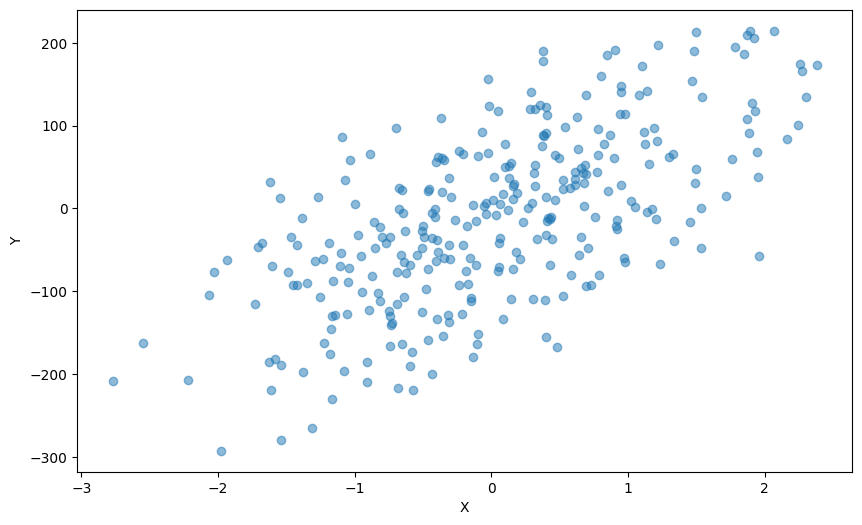

In [2]:
X, y = make_regression(
    n_samples=300, n_features=1, n_targets=1, noise=80, random_state=0
)

# make_regression returns NumPy arrays. Turn them into JAX arrays
X = jnp.array(X)
y = jnp.array(y).reshape(
    -1, 1
)  # transfer to (rows, columns). (-1,1) gives column vector (1 column and -1 means figure out how many rows).

# n_samples is the number of data points (N in the notebook)
# n_features and n_targets: the dimensionality of the data points. Setting them both 1 means R x R
# random state: if this is not specified, new random data will be generated with each execution
# noise: how much random Gaussian noise is added to the Y values. Here, 80 is the standard deviation of this noise (e.g. if 0 you get a straight line).

# plot the data
plt.figure(figsize=(10, 6))
plt.xlabel("X")
plt.ylabel("Y")
plt.scatter(X, y, alpha=0.5)  # alpha = transparency of the data points colour

We now define the least-squares problem. The objective function in this case is
$$L(a,b) = \dfrac{1}{2N} \sum_{i=1}^N |ax_i+b-y_i|^2,$$
where $a,b \in \mathbb{R}$ are the parameters to be determined, and $N =300$ in our example.
This can be written in matrix form. Set $\theta=(a,b)^\top \in \mathbb{R}^2$, then we have
$$ L(\theta) = \dfrac{1}{2} \| A \theta - y \|^2_2 ,$$
where $A \in \mathbb{R}^{N \times 2}$ and $y \in \mathbb{R}^N$ are given by

$$ A = \begin{bmatrix} x_1 & 1 \\ x_2 & 1 \\ \vdots & \vdots \\ x_N & 1 \end{bmatrix}, \quad \quad y = \begin{bmatrix} y_1 \\ y_2 \\ \vdots \\ y_N \end{bmatrix} $$

In [3]:
A = jnp.column_stack([X, jnp.ones_like(X)])  # creates A = [[X] [1]]


# the objective function = mean squared distance
def loss(theta, A, y):
    return jnp.mean(((A @ theta) - y) ** 2)


# respect the order here. Differentiation is w.r.t first argument unless specified otherwise
grad_loss = jax.grad(loss)  # argnums by default = 0. i.e. first argument

The closed-form solution is given by
$$\theta = (A^\top A)^{-1}(A^\top y). $$

In [4]:
# closed form of the solution (consult week 3 talk)

# Note that we don't use the more numerically stable version of the closed-form solution
# based on the QR decomposition. This would, in general, be preferable.
theta_closed = jnp.array(jnp.linalg.inv(A.T @ A) @ (A.T @ y))
print(theta_closed)

[[ 67.38458 ]
 [-13.396084]]


Perform the gradient descent method to find an approximate $\theta^*$.

In [5]:
# Gradient Descent
# an initial value
theta_gd = jnp.array([[0.0, 0.0]]).T

mu = jnp.min(jnp.linalg.eigvals(A.T @ A))
delta = jnp.max(jnp.linalg.eigvals(A.T @ A))

# jnp.linalg.eigvals always returns complex numbers

alpha = 2 / (jnp.real(mu + delta))


gd_losses = []  # to keep track of the loss at each iteration


# iterations of the gradient descent

N_STEPS = 1_000

for k in range(N_STEPS):
    grad_gd = grad_loss(theta_gd, A, y)

    theta_gd -= alpha * grad_gd  # theta_gd = theta_gd - alpha *g
    gd_losses.append(loss(theta_gd, A, y))

    if k % 100 == 0:
        print(f"Loss function value at step {k}: {gd_losses[k]}")


print("Using Gradient Descent, theta^* =", theta_gd)

Loss function value at step 0: 10810.2666015625
Loss function value at step 100: 7418.9326171875
Loss function value at step 200: 6518.1708984375
Loss function value at step 300: 6278.63427734375
Loss function value at step 400: 6214.8603515625
Loss function value at step 500: 6197.86279296875
Loss function value at step 600: 6193.32666015625
Loss function value at step 700: 6192.1142578125
Loss function value at step 800: 6191.79052734375
Loss function value at step 900: 6191.7041015625
Using Gradient Descent, theta^* = [[ 67.29677 ]
 [-13.363441]]


Plot the Gradient Descent solution against the closed-form solution for comparison.

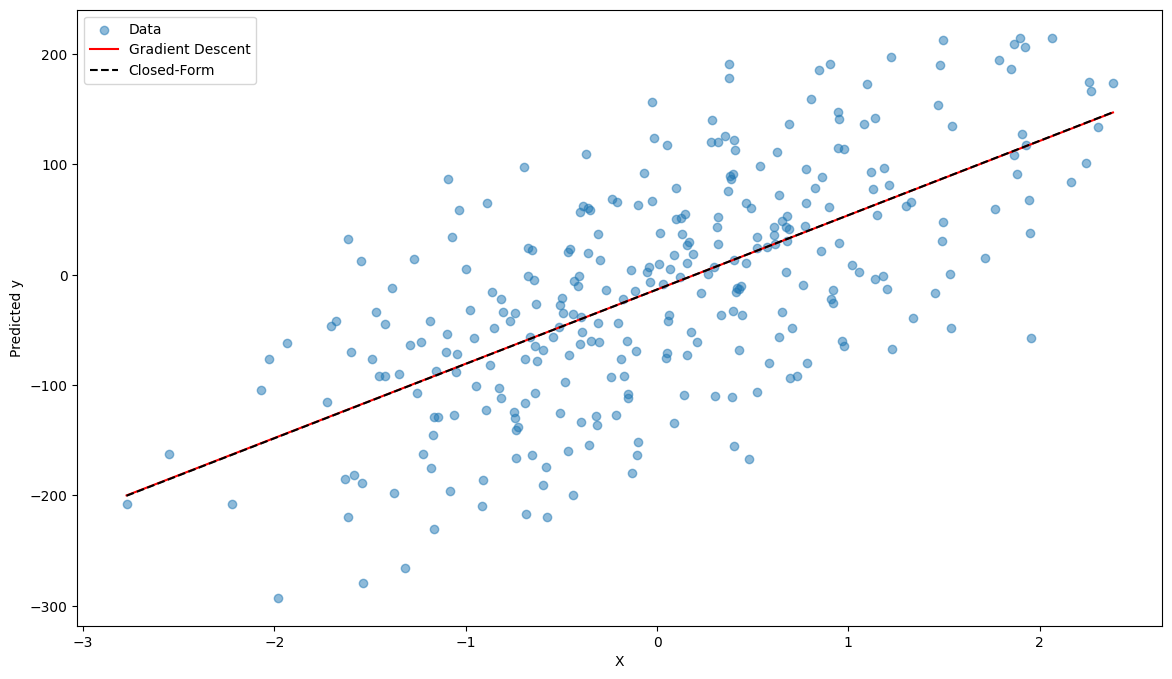

In [6]:
# setting-up the plot
plt.figure(figsize=(14, 8))
x_plot = jnp.linspace(X.min(), X.max(), 100)
plt.xlabel("X")
plt.ylabel("Predicted y")

# plot data points
plt.scatter(
    X, y, label="Data", alpha=0.5
)  # alpha = transparency of the data points color

# create lines to be fitted
y_gd = theta_gd[0, 0] * x_plot + theta_gd[1, 0]  # from GD solution
y_exact = theta_closed[0, 0] * x_plot + theta_closed[1, 0]  # from closed-form solution

# plotting the lines
plt.plot(x_plot, y_gd, label="Gradient Descent", color="red")
plt.plot(x_plot, y_exact, label="Closed-Form", linestyle="--", color="black")
plt.legend()

Now, we introduce the mini-batch gradient descent. In the following, epoch refers to a complete pass through the entire data set. This suggests that the performance of the model can be evaluated after each epoch. We thus calculate the loss function at the end of each epoch iteration. In each epoch, we choose a mini-batch, and use it to update the gradient, then update the required parameter $\theta^*$ using this noisy gradient. After scanning through all of our data points, we are ready to start a new epoch. We can also observe the loss function values after each mini-batch iteration.

In [7]:
# Mini-batch Gradient Descent
batch_size = 63
epochs = 135  # cycle through the entire data set 135 times
theta_mbgd = jnp.array([[0.0, 0.0]]).T
# record two kinds of losses: 1-error after each mini-batch iteration, 2-error after each epoch iteration
mbgd_losses1 = []
mbgd_losses2 = []

np.random.seed(0)  # to reproduce the same random number each time you execute


# iterations of the mini-batch gradient descent
for epoch in range(epochs):
    indices = np.random.permutation(
        len(y)
    )  # to generate a random permutation of size len(y)

    # shuffle data to randomise the order
    A_shuffled = A[
        indices
    ]  # to shuffle the rows of A according to the permutation "indices"
    y_shuffled = y[indices]

    batch_loss = []

    for i in range(0, len(y), batch_size):
        # if len(y) not divisible by batch_size, loop handles it by taking a smaller batch_size (i.e. last batch_size = len(y) mod batch_size)

        # take a batch of size batch_size
        A_batch = A_shuffled[
            i : i + batch_size, :
        ]  # take only row i until row i + batch_size. Take all columns
        y_batch = y_shuffled[i : i + batch_size, :]

        # to see the size of each batch taken (in this example we get 5 mini-batches of sizes: 63, 63, 63, 63 and 48)
        batch_size_actual = A_batch.shape[0]
        ##print(batch_size_actual)

        # usual gradient descent but with the mini-batch
        grad_batch = grad_loss(theta_mbgd, A_batch, y_batch)
        theta_mbgd -= alpha * grad_batch

        # keep track of loss at each mini-batch iteration
        batch_loss.append(loss(theta_mbgd, A_batch, y_batch))

    mbgd_losses1.extend(batch_loss)  # append for elements, extend for lists
    mbgd_losses2.append(loss(theta_mbgd, A, y))


print("Using Gradient Descent, theta^* =", theta_mbgd)

Using Gradient Descent, theta^* = [[ 66.649284]
 [-13.231985]]


Plot the Mini-batch Gradient Descent solution against the closed-form and the Gradient Descent solutions for comparison.

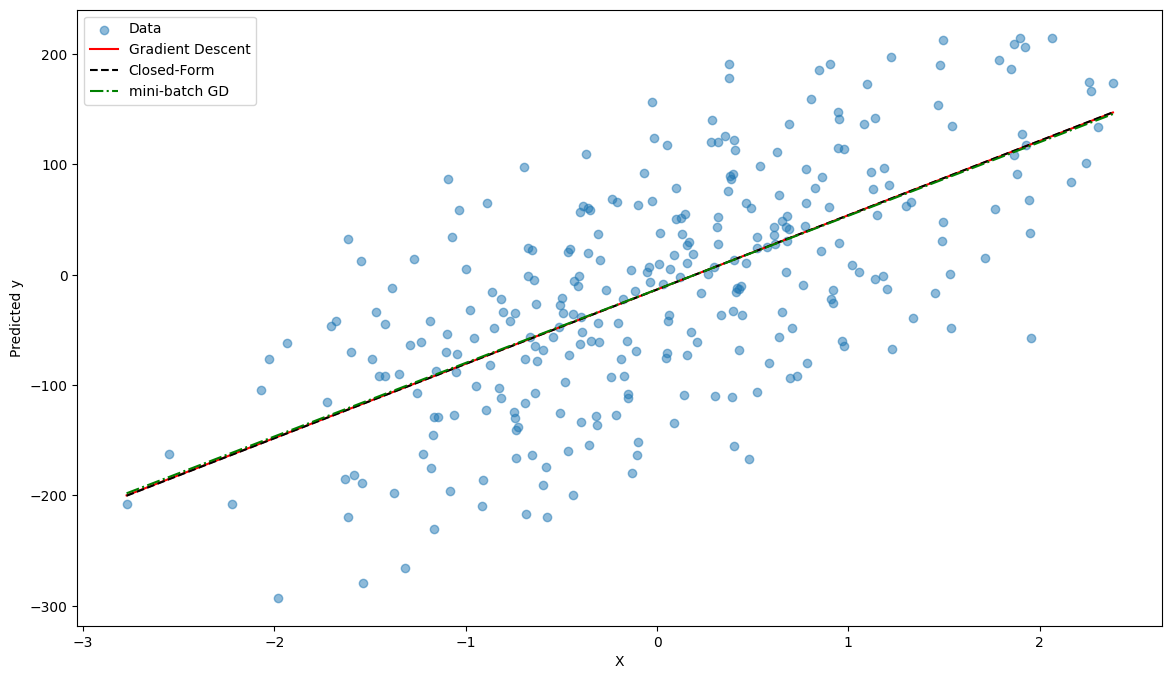

In [8]:
# setting-up the plot
plt.figure(figsize=(14, 8))
x_plot = jnp.linspace(X.min(), X.max(), 100)
plt.xlabel("X")
plt.ylabel("Predicted y")

# plot data points
plt.scatter(X, y, label="Data", alpha=0.5)

# create the lines
y_gd = theta_gd[0, 0] * x_plot + theta_gd[1, 0]  # GD
y_exact = theta_closed[0, 0] * x_plot + theta_closed[1, 0]  # closed-form
y_mbgd = theta_mbgd[0, 0] * x_plot + theta_mbgd[1, 0]  # mini-batch GD

# plot the lines
plt.plot(x_plot, y_gd, label="Gradient Descent", color="red")
plt.plot(x_plot, y_exact, label="Closed-Form", linestyle="--", color="black")
plt.plot(x_plot, y_mbgd, label="mini-batch GD", linestyle="-.", color="green")

plt.legend()

Finally, we compare the decay of the loss function for the Gradient Descent and the Mini-batch Gradient Descent. For the latter, we plot the loss function values after each mini-bath iteration (in red), and after each epoch (in green).

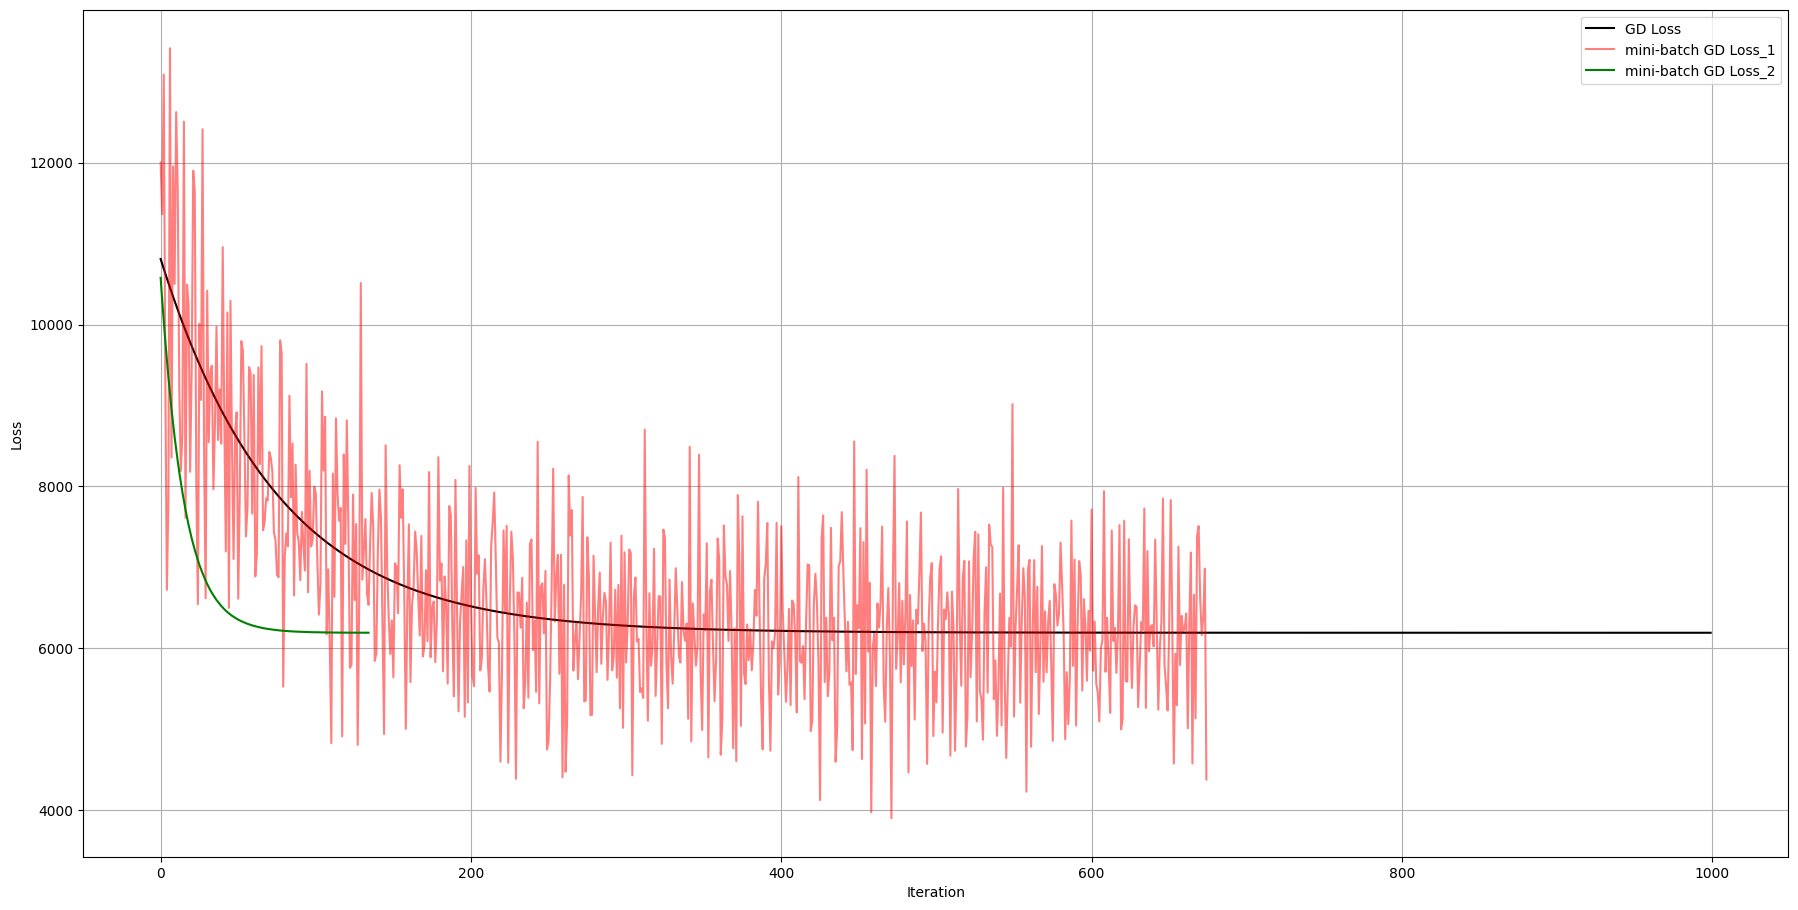

In [9]:
# convergence plot (decrease in loss function)

# setting-up the plots
plt.figure(figsize=(22, 11))
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.grid(True)

# for GD
plt.plot(gd_losses, label="GD Loss", color="black")

# for mini-batch GD after each mini-batch (mbgd_losses1)
plt.plot(mbgd_losses1, label="mini-batch GD Loss_1", alpha=0.5, color="red")

# for mini-batch GD after each epoch (mbgd_losses2)
plt.plot(mbgd_losses2, label="mini-batch GD Loss_2", color="green")

plt.legend()

<b>More to explore (easier to harder):</b>
* Accelerated Gradient Descent: try implementing Nesterov acceleration and see if it is indeed faster as the theory dictates;

* Real Machine Learning Examples: try using these methods on an actual machine learning problem where the data can be more noisy, the objective function can be more complicated, or the learning rate is a non-constant;

* User-Friendly Code: this code is constructed around our least-square example (objective function, learning rate, data generated...etc). How about giving the user the freedom of choosing?

* Object-Oriented Programming: this is an advanced programming style that designs your code as objects. A good start would be to learn about `Class` in python, and then check [Object-Oriented Programming (OOP) in Python](https://realpython.com/python3-object-oriented-programming/).

<b>Useful online resources (Last accessed: 20 May 2025):</b>
* [Guide to Gradient Descent Algorithm: A Comprehensive implementation in Python](https://machinelearningspace.com/a-comprehensive-guide-to-gradient-descent-algorithm/);

* [Stochastic Gradient Descent Algorithm With Python and NumPy](https://realpython.com/gradient-descent-algorithm-python/);

* [Stochastic Gradient Descent in Python: A Complete Guide for ML Optimization](https://www.datacamp.com/tutorial/stochastic-gradient-descent?dc_referrer=https%3A%2F%2Fwww.google.com%2F).